# waypoints

## define agents

In [24]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [40]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"./f1tenth_gym/examples/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='SILVERSTONE')

## create waypoints

In [41]:

done = False
env = WPEnv(map_name='SILVERSTONE_TRAIN3', begin_pos=[0, 0, np.pi+1])
obs = env.reset()
agent = FGAgent(speed=3.0)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [42]:
with open('ss3-wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [31]:
import numpy as np

with open('ss2-wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[52][:2])
print(dist)
print(len(wps))
print(len(wps)//300)

0.8745604745519705
15578
51


In [33]:
from tqdm import tqdm

map_name = 'SILVERSTONE_TRAIN2'
env = gym.make('f110_gym:f110-v0', map=f"./f1tenth_gym/examples/{map_name}", map_ext='.png', num_agents=1)

for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.5:
        print(min(obs['scans'][0]))
        

  3%|▎         | 441/15578 [00:00<00:06, 2220.17it/s]

0.4861406010136173
0.4861406010136173
0.4966346217096672
0.4946310243837726
0.4650440434137921
0.47571143985191683
0.4718700112162928


100%|██████████| 15578/15578 [00:06<00:00, 2299.68it/s]


In [44]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

0

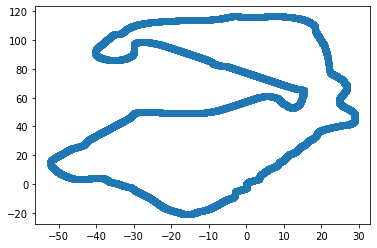

In [45]:
import matplotlib.pyplot as plt

plt.scatter(wps[:,0], wps[:, 1])

# environment

In [2]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=12.0,
                 n_cps = 200,
                 cp_reward = 0.1,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='SILVERSTONE_TRAIN',
                 safe_padding=0.3,
                 laps = 1.0,
                 max_t=1000
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.max_t = 500
        self.v_hist = []
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1, 2, 3])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/ss{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/ss-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.max_t = 500
        self.v_hist = []
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            
        else:
            dists = cdist([[0,0]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = [0., 0., np.pi+1]
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        scanner = scanner[3*70:3*290]
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
#         if self.test_map_name is None:
#             noise = np.random.normal(loc=0.0, scale=0.03, size=state.shape)
#             state = state + noise
        
        return state
    
    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 10)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.v_hist.append(act_v/self.max_v)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        
        th = action[1]*np.pi/6
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            if self.test_map_name is not None:
                print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        if self.t > self.max_t and np.mean(self.v_hist)>0.8:
            print(f"agent on {self.map_path} got reward {self.cum_r}, mean vel: {np.mean(self.v_hist)}")
            done = True
            reward = np.mean(self.v_hist)
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += -0.05
            self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset()

array([0.2062653 , 0.2134505 , 0.21404672, 0.21305871, 0.20573085,
       0.21361601, 0.21374704, 0.21427141, 0.22118291, 0.2174321 ,
       0.21847276, 0.21837244, 0.21701169, 0.22141467, 0.22289008,
       0.22780011, 0.22905079, 0.22685324, 0.22770504, 0.22836908,
       0.23417574, 0.23747521, 0.24741139, 0.24544898, 0.25208586,
       0.24912499, 0.24856821, 0.25256904, 0.25927777, 0.26081881,
       0.26882448, 0.2752598 , 0.28209054, 0.28734337, 0.28883785,
       0.29107824, 0.29186506, 0.30455751, 0.31016841, 0.34346556,
       0.35193637, 0.3819769 , 0.48066785, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

# training

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 30,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 30000,
    'sgd_minibatch_size': 512,
    'batch_mode': 'truncate_episodes',
    'lr': .001,
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
# trainer.restore('../checkpoints/v2.0/checkpoint_000061/checkpoint-61')

print(trainer.config)
rewards = []
best_reward = -100
models_path = '../checkpoints'

import pickle

for i in range(300):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/v2.3_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0 and episode_r > best_reward:
        best_reward = episode_r
        cp = trainer.save(f"{models_path}/v2.3")
        print("checkpoint saved at", cp)


2022-04-13 18:45:13,031	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-13 18:45:13,032	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=53480) 2022-04-13 18:45:20,235	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=53479) 2022-04-13 18:45:22,790	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=53474) 2022-04-13 18:45:22,854	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.

2022-04-13 18:45:27,627	INFO trainable.py:125 -- Trainable.setup took 14.597 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-04-13 18:45:27,629	WARNING util.py:55 -- Install gputil for GPU system monitoring.


{'num_workers': 30, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.001, 'train_batch_size': 30000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_pre

2022-04-13 18:45:49,623	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:-0.9381944444444444
checkpoint saved at ../checkpoints/v2.3/checkpoint_000001/checkpoint-1
episode: 1 reward:-0.8827067669172933
episode: 2 reward:-0.853125
episode: 3 reward:-0.741
episode: 4 reward:-0.5595
episode: 5 reward:-0.38549999999999995
checkpoint saved at ../checkpoints/v2.3/checkpoint_000006/checkpoint-6
episode: 6 reward:-0.1409999999999998
episode: 7 reward:0.04000000000000032
episode: 8 reward:0.3280000000000001
episode: 9 reward:0.7565000000000001
episode: 10 reward:1.2494999999999994
checkpoint saved at ../checkpoints/v2.3/checkpoint_000011/checkpoint-11
episode: 11 reward:1.4669999999999994
episode: 12 reward:1.809499999999999
episode: 13 reward:2.1309999999999985
episode: 14 reward:2.3164999999999982
episode: 15 reward:2.860499999999998
checkpoint saved at ../checkpoints/v2.3/checkpoint_000016/checkpoint-16
episode: 16 reward:3.304499999999996
episode: 17 reward:3.752999999999995
episode: 18 reward:4.083499999999994
episode: 19 reward:4.265999999999

episode: 101 reward:6.176000000000003
episode: 102 reward:6.497000000000002
episode: 103 reward:6.527000000000002
episode: 104 reward:6.625000000000004
episode: 105 reward:6.213000000000002
episode: 106 reward:6.050500000000002
episode: 107 reward:6.1655000000000015
episode: 108 reward:5.886500000000001
episode: 109 reward:5.4529999999999985
episode: 110 reward:5.349499999999997
episode: 111 reward:4.9344999999999954
episode: 112 reward:4.910499999999995
episode: 113 reward:5.060999999999996
episode: 114 reward:5.402499999999996
(RolloutWorker pid=53448) agent on ../maps/SILVERSTONE_TRAIN2 got reward 7.24999999999999 in 30.33000000000194. RETURNED
episode: 115 reward:5.698499999999998
episode: 116 reward:6.277500000000003
episode: 117 reward:6.877500000000007
episode: 118 reward:7.412000000000007
episode: 119 reward:7.3900000000000095
episode: 120 reward:7.652000000000008
episode: 121 reward:8.374500000000017
episode: 122 reward:8.59200000000002
episode: 123 reward:8.52300000000002
epi

episode: 227 reward:5.235999999999999
(RolloutWorker pid=53471) agent on ../maps/SILVERSTONE_TRAIN3 got reward 3.1000000000000014 in 12.009999999999788. RETURNED
episode: 228 reward:5.452999999999999
episode: 229 reward:4.9815
episode: 230 reward:4.953499999999998
episode: 231 reward:4.4510000000000005
episode: 232 reward:4.366499999999998
(RolloutWorker pid=53460) agent on ../maps/SILVERSTONE_TRAIN1 got reward 0.30000000000000004 in 4.099999999999957. RETURNED
episode: 233 reward:4.272499999999997
(RolloutWorker pid=53467) agent on ../maps/SILVERSTONE_TRAIN3 got reward 6.499999999999993 in 21.69000000000059. RETURNED
episode: 234 reward:3.8889999999999985
episode: 235 reward:4.052
episode: 236 reward:4.616999999999997
episode: 237 reward:4.509999999999999
episode: 238 reward:3.822999999999997
episode: 239 reward:3.7344999999999966
(RolloutWorker pid=53474) agent on ../maps/SILVERSTONE_TRAIN1 got reward 9.149999999999984 in 27.930000000001566. RETURNED
episode: 240 reward:4.02449999999

In [1]:
!rm -rf ../checkpoints/v2.3

## evaluation

In [6]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/v2.2/checkpoint_000031/checkpoint-31')



2022-04-13 15:39:29,384	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-04-13 15:39:29,386	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-04-13 15:39:29,405	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/v2.2/checkpoint_000031/checkpoint-31
2022-04-13 15:39:29,406	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 31, '_timesteps_total': 6199380, '_time_total': 1542.2936189174652, '_episodes_total': 4604}


In [ ]:
done = False
env = F110RaceEnv({}, test_map_name='SILVERSTONE_OBS', laps=2)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

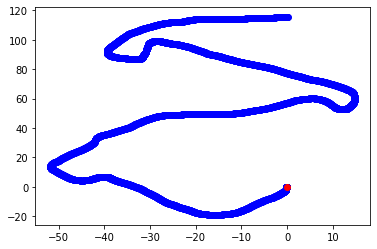

In [8]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

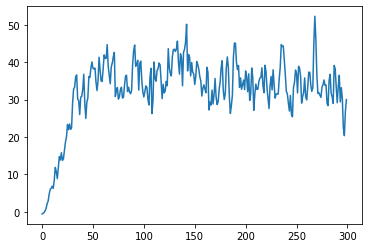

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

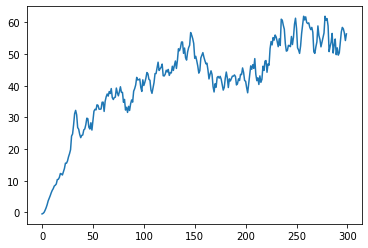

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v1.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

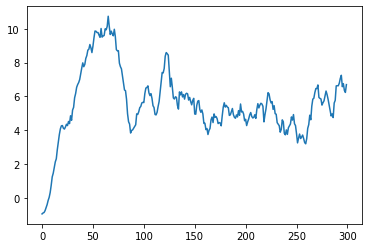

In [6]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/v2.3_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
